In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.signal import butter, iirnotch, firwin, filtfilt, periodogram

In [2]:
import pyemgpipeline as pep

In [3]:
def data_from_files(data, metadata):
    sess_data = pd.read_csv(data,header=None)
    sess_metadata = pd.read_csv(metadata, names=['start_time','category'])
    category_instances = {}
    for i, row in sess_metadata.iterrows():
        start_time = row['start_time']
        category = row['category'].strip()
        end_time = sess_metadata.iloc[i + 1]['start_time'] if i < len(sess_metadata) - 1 else None

        instances = sess_data.loc[(sess_data[0] >= start_time) & (sess_data[0] < end_time)].iloc[:,[2,3,6,7]]

        if category not in category_instances:
            category_instances[category] = []
        category_instances[category].append(instances)
    return category_instances

In [4]:
def plot_emg(cat_dict, category, instance, electrode, lo=0, hi=0, plot=True):
    series = cat_dict[category][instance][electrode]
    signal = series - series.mean()
    if lo > 0 and hi > 0:
        signal = butter_band(signal, 250, lo, hi)
    if plot:
        plt.plot(signal)
        plt.title(f'{category}: {instance}, electrode {electrode}')
    return signal

In [5]:
def butter_band(chan_data, Fs, low, high):
    # Define the filter parameters
    nyquist_freq = 0.5 * Fs
    lowcut = low / nyquist_freq
    highcut = high / nyquist_freq
    order = 2

    # Create the filter coefficients
    b, a = butter(order, [lowcut, highcut], btype='band')

    # Apply the filter to the EEG data
    filtered_data = filtfilt(b, a, chan_data)
    return filtered_data

In [6]:
sess0_data = 'test_sess0_data.txt'
sess0_metadata = 'test_sess0_metadata.txt'
cat_instances = data_from_files(sess0_data, sess0_metadata)

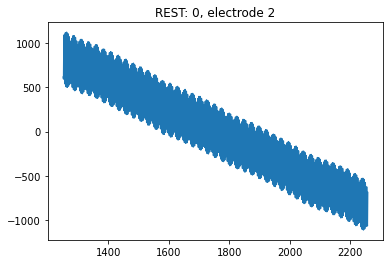

In [7]:
sig_rest02 = plot_emg(cat_instances, 'REST', 0, 2)

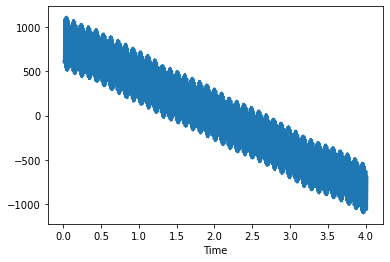

In [8]:
m = pep.wrappers.EMGMeasurement(np.array(sig_rest02), hz=250)
m.apply_dc_offset_remover()
m.plot()

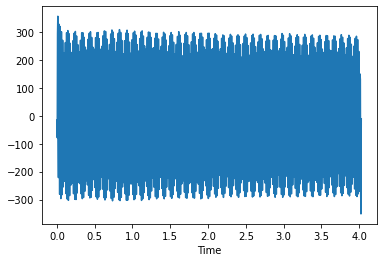

In [9]:
m.apply_bandpass_filter(2,10,124)
m.plot()

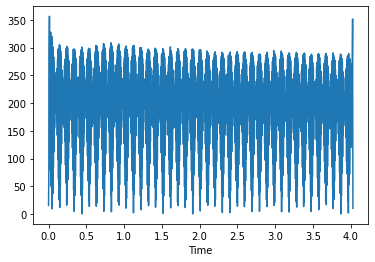

In [10]:
m.apply_full_wave_rectifier()
m.plot()

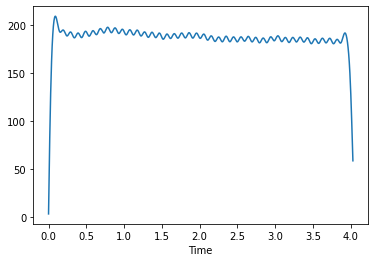

In [11]:
m.apply_linear_envelope()
m.plot()

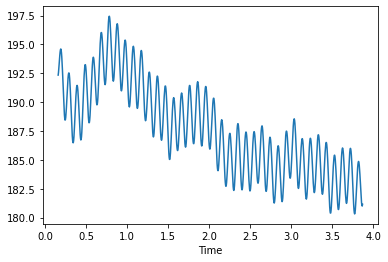

In [12]:
m.apply_end_frame_cutter(n_end_frames=40)
m.plot()